In [83]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [84]:
import numpy as np

In [85]:
import scipy.io as sio

In [86]:
df = sio.loadmat('snelson1d.mat')

In [87]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [88]:
M = 7
N_star = 30
N_samples = 1200

In [89]:
X_u_noisy = np.linspace(0,6, M)[:, None]

In [90]:
stan_code_var = """
data {
    int<lower=1> N;
    int<lower=1> M;
    real x[N];
    vector[N] y;
    real xu[M];

}
transformed data {
    real jitter = 1e-6;
//     real rho = 0.9;
//     real alpha = 0.85;
//     real sigma = 0.12;
}

parameters {
    real<lower=1e-6> sigma;
     real <lower=1e-6> alpha;
     real<lower=1e-6> rho;
    
    vector[M] eta;
    vector[M] u;
    
}

transformed parameters{
   // matrix[M, M] R;
}
model {
    vector[N] mu;
    matrix[N, N] f_cov;
    matrix[N, N] S;
    matrix[M, N] A;
    matrix [N,N] Qff;
    matrix [N,N] L_fitc;
    matrix[N, N] K_tilde;
    matrix[N, N] K_tilde_inv;
    matrix[M, M] R;
    
    matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
    matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
    matrix[N, N] K = cov_exp_quad(x, alpha, rho);
    vector[M] Kuu_inv_u;

        
         for (m in 1:M)
             Kuu[m, m] = Kuu[m, m] + jitter;
        
        // RRT = Kuu
    R = cholesky_decompose(Kuu);
        
    {
                  
        //A = R^{-1}Kuf   or A = R\Kuf
        A = mdivide_left_tri_low(R, Kfu');
        
        // mu = A'v
        //  v = N(0, I)
        mu = A'*eta;
        
        // Qff = A'A
        Qff = A'*A;
        S = K - Qff;
        
        for (i in 1:N){
            for(j in 1:N){
                K_tilde[i,j] = 0.0;
                K_tilde_inv[i,j] = 0.0;
            }
            K_tilde[i,i] = S[i,i];
            K_tilde_inv[i,i] = 1./ S[i,i];
        }
        
    }
  
#     rho ~ inv_gamma(5, 5);
#     alpha ~ normal(0, 1);

// strongly informative priors, but with these the covariance matrix will be more well behaved in my experience.
// The mean of the Gaussian priors is close to the optimised MAP value of the hyperparameters.

    rho ~ normal(0.90, 0.25);
    alpha ~ normal(0.85, 0.25);
    eta ~ normal(0, 1);

    sigma ~ normal(0, 0.60);
    
    
    // exp(L1) = log(N(y_i| mu_i, sigma)*exp(-0.5*K_tilde_ii/sigma))
    // Equation 2 of Hensman, et al. Gaussian Processes for Big Data UAI 2013.
    // This is the analytical soln. of expectation of log likelihood under conditional Guassian: P(F|U).
    // K_tilde_ii = diag(Kff - Qff)[i,i]
    
    
    for(i in 1:N){
 //       target += -square((y[i] - mu[i]))/(2*square(sigma));
//        target += normal_lpdf(y[i] | mu[i], sigma);
//        target += (-0.5*K_tilde[i,i]/sigma);
        
        target += normal_lpdf(y[i] | mu[i], sigma);
        target += (-0.5*K_tilde[i,i]/sigma);
    }
}


"""

In [91]:
stan_model_var = pystan.StanModel(model_code=stan_code_var)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ff73dcb019635409dc7fffef8e230ecb NOW.


In [94]:
gp_var_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':M, 'xu':X_u_noisy.flatten()}

In [95]:
fit_var= stan_model_var.sampling(data=gp_var_data, iter=N_samples, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [97]:
samples = fit_var.extract()


In [98]:
print(fit_var)

Inference for Stan model: anon_model_ff73dcb019635409dc7fffef8e230ecb.
2 chains, each with iter=1200; warmup=600; thin=1; 
post-warmup draws per chain=600, total post-warmup draws=1200.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma    0.46  7.0e-4   0.02   0.41   0.44   0.46   0.47   0.51   1164    1.0
alpha    0.89  5.6e-3   0.15   0.62   0.78   0.87   0.98   1.23    765    1.0
rho      0.95  2.1e-3   0.07   0.81    0.9   0.95   0.99    1.1   1200    1.0
eta[0]   0.27  4.4e-3   0.15  -0.02   0.17   0.26   0.36   0.57   1200    1.0
eta[1]  -2.57    0.02   0.41  -3.38  -2.83  -2.56  -2.29  -1.82    677    1.0
eta[2]    0.9  9.8e-3   0.34   0.28   0.67   0.89   1.11   1.63   1173    1.0
eta[3]   0.08  7.6e-3   0.26  -0.42  -0.07   0.08   0.25    0.6   1131    1.0
eta[4]   0.35  6.3e-3    0.2-6.9e-3   0.22   0.34   0.48   0.75    984    1.0
eta[5]  -0.49  7.1e-3   0.22  -0.96  -0.62  -0.47  -0.32   -0.1    992    1.0
eta[6]  -0.85    0.01   0.35  -1.

In [99]:
# mu = samples['mu']
print(list(samples.keys()))
# sigma_mean = np.mean(mu, axis=0)

['sigma', 'alpha', 'rho', 'eta', 'u', 'lp__']


In [100]:
sigma_samples = samples['sigma']
alpha_samples = samples['alpha']
rho_samples = samples['rho']

In [101]:
sigma_mean = np.mean(samples['sigma'])
sigma_median = np.nanmedian(samples['sigma'])

l_mean = np.mean(samples['rho'])
l_median = np.nanmedian(samples['rho'])

sigvar_mean = np.mean(samples['alpha'])
sigvar_median = np.nanmedian(samples['alpha'])

print("mean of noise variance: %.2f" % sigma_mean)
print("median of noise variance: %.2f"% sigma_median)
print("mean of lengthscale: %.3f"% l_mean)
print("median of lengthscale: %.3f"% l_median)
print("mean of signal variance: %.3f"% sigvar_mean)
print("median of signal variance: %.3f"% sigvar_median)

mean of noise variance: 0.46
median of noise variance: 0.46
mean of lengthscale: 0.951
median of lengthscale: 0.951
mean of signal variance: 0.885
median of signal variance: 0.871


In [102]:
eta = samples['eta']

In [103]:
print(eta.shape)

(1200, 7)


In [104]:
eta_mean = np.mean(samples['eta'], axis=0)
eta_median = np.nanmedian(samples['eta'], axis=0)

In [105]:
eta_perc_25 = np.percentile(eta, 2.5, axis=0)
eta_perc_975 = np.percentile(eta, 97.5, axis=0)

#### Plotting posterior distribution of v.

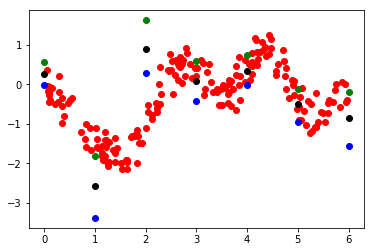

In [106]:
plt.plot(X,Y, 'ro')
plt.plot(X_u_noisy, eta_perc_25, 'bo')
plt.plot(X_u_noisy, eta_perc_975, 'go')
plt.plot(X_u_noisy, eta_mean, 'ko')

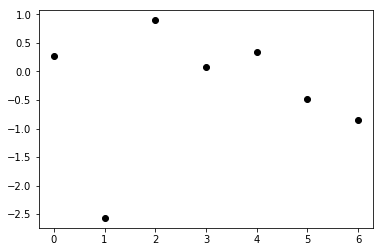

In [107]:
plt.plot(X_u_noisy, eta_mean, 'ko')

In [108]:

class ProcessStanSamples(object):
    
    def _params_samples(samples):
        keys = list(samples.keys())
        return keys
    
    def plot_histograms(samples):
        sigma_samples = samples['sigma']
        rho_samples = samples['rho']
        alpha_samples = samples['alpha']
        if 'f' in self._params_samples(samples):
            f_samples = samples['f']
        
        if 'u' in self._params_samples(samples):
            u_samples = samples['u']
        
        
        f, axs = plt.subplots(2,2, sharey=True)
        axs[0,0].hist(sigma_samples)
        axs[0,0].set_title('Plotting samples for sigma')
        axs[0,0].legend(['Noise variance'])
        axs[0,1].hist(rho_samples)
        axs[0,1].set_title('Plotting samples for lengthscale')
        axs[0,1].legend(['lengthscale'])
        axs[1,0].hist(alpha_samples)
#         axs[1,0].set_title('Plotting samples for signalvariance')
        axs[1,0].legend(['signal var'])
    
    
        
    

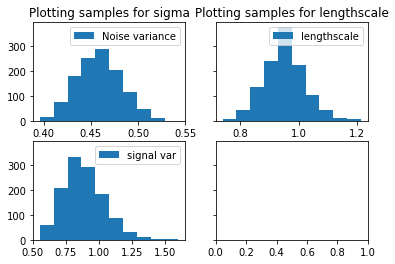

In [109]:
f, axs = plt.subplots(2,2, sharey=True)
axs[0,0].hist(sigma_samples)
axs[0,0].set_title('Plotting samples for sigma')
axs[0,0].legend(['Noise variance'])
axs[0,1].hist(rho_samples)
axs[0,1].set_title('Plotting samples for lengthscale')
axs[0,1].legend(['lengthscale'])
axs[1,0].hist(alpha_samples)
# axs[1,0].set_title('Plotting samples for signalvariance')
axs[1,0].legend(['signal var'])

In [110]:
eta_samples = samples['eta']

In [111]:
N_star = 30
X_star = np.linspace(-1, 7.0, N_star)[:, None]

In [112]:
print(alpha_samples.shape)

(1200,)


In [113]:
def kernel_rbf(alpha, rho, Xi, Xj=None):
    if Xj is None:
        Xj = Xi
    
    N1,D1 = Xi.shape[0],1
    N2,D2 = Xj.shape[0],1
    
    diff = Xi.reshape(N1,1,D1) - Xj.reshape(1,N2,D2)
    K = (alpha**2)*np.exp(-0.5*np.sum(np.square(diff),-1)/(rho)**2)
    return K
    

In [114]:
Kuu = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_u_noisy)

In [115]:
K_star_u = kernel_rbf(alpha=1.0, rho =0.8, Xi=X_star, Xj=X_u_noisy)

####  Utility function to generate predictive distribution:

$p(f^*|y) = \int \int p(f^*|u) q(u, \theta) du d\theta$

We will obtain the above expression using MCMC samples. The stan code above samples from the optimal variational distribution $q(u,\theta)$. 

In [116]:
# function to generate mean and covariance matrics ..

def generate_preds(alpha, rho, v, Xi, Xj):
    Kuu = kernel_rbf(alpha, rho, Xi=X_u_noisy)
    K_star_u = kernel_rbf(alpha, rho, Xi=X_star, Xj=X_u_noisy)
    K_star_star = kernel_rbf(alpha, rho, Xi=X_star)
    
    R = np.linalg.cholesky(Kuu)
    A = np.linalg.solve(R, np.transpose(K_star_u))
#     print(A.shape)
    A_T = np.transpose(A)
    f_star_mean = np.dot(A_T, v)
    Q_star_star = np.dot(A_T, A)
    
    S = K_star_star - Q_star_star
    return f_star_mean, S



####   Plot for predictive distribution for Snelson dataset using samples obtained from optimal variational distribution : q(v, $\theta$)

In [117]:
N_full = 400

In [118]:
f_sum = np.zeros(N_star)
f_sum2 = np.zeros(N_star)
S_sum = np.zeros((N_star,N_star))
S_diag = np.zeros(N_star)
for i in range(N_samples):
    f_star_mean, S = generate_preds(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:],  Xi=X_star, Xj=X_u_noisy)
    f_sum = f_sum + f_star_mean
    f_sum2 = f_sum2 + f_star_mean**2
    S_sum = S_sum + S
    S_diag = np.diag(S)
    

In [119]:
cov_fin = S_diag/N_samples + f_sum2/N_samples - (f_sum/N_samples)**2

In [120]:
f_fin = f_sum / N_samples
S_sum = S_sum / N_samples

In [121]:
print(f_fin)

[ 0.86929845  0.94934334  0.85603285  0.54023597  0.01686261 -0.6199861
 -1.21812189 -1.6214935  -1.73262964 -1.5502332  -1.16206921 -0.69949219
 -0.28081651  0.02716795  0.21552814  0.31316606  0.35767463  0.37326937
  0.36321385  0.31517161  0.21333306  0.0509837  -0.16109946 -0.39329643
 -0.60384353 -0.75174344 -0.81078219 -0.77817546 -0.67371991 -0.53040773]


In [122]:
print(np.diag(S_sum))

[4.46493411e-01 2.56676318e-01 9.47341484e-02 1.13014168e-02
 2.57630390e-03 1.54345696e-02 1.10252133e-02 5.54098208e-04
 3.91562891e-03 9.83571502e-03 4.40975879e-03 1.04844274e-04
 5.98738788e-03 7.98705464e-03 1.50540598e-03 1.50540598e-03
 7.98705464e-03 5.98738788e-03 1.04844274e-04 4.40975879e-03
 9.83571502e-03 3.91562891e-03 5.54098208e-04 1.10252133e-02
 1.54345696e-02 2.57630390e-03 1.13014168e-02 9.47341484e-02
 2.56676318e-01 4.46493411e-01]


In [123]:
print(cov_fin)

[0.06463184 0.05782285 0.04229258 0.02571032 0.01359645 0.00796028
 0.00753319 0.00798444 0.00640866 0.00500767 0.00605058 0.00716573
 0.0061969  0.00520085 0.00577405 0.00616242 0.00546644 0.00516069
 0.00545666 0.0052872  0.00532933 0.00637807 0.00689015 0.00673212
 0.01020534 0.02045556 0.03339217 0.04110743 0.0396711  0.03134571]


In [126]:
print(cov_fin[5])
print(np.diag(S_sum)[5])

0.007960279628456857
0.015434569598310327


####  Plot for the mean function

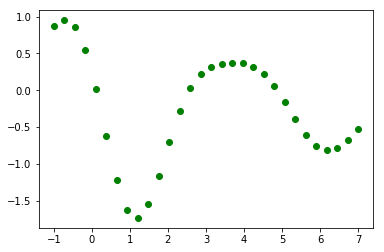

In [127]:
plt.plot(X_star, f_fin, 'go')

In [128]:

a = np.random.multivariate_normal(f_fin, S_sum, 6)

In [129]:
a2 = np.random.multivariate_normal(f_fin, np.diag(cov_fin), 8)

In [44]:
print(a.shape)

(6, 30)


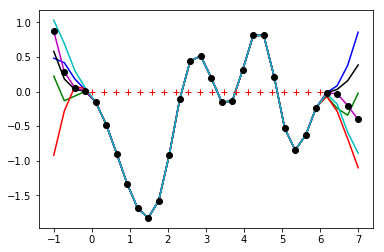

In [80]:
plt.plot(X_star, a[0], 'g-')
plt.plot(X_star, a[1], 'b-')
plt.plot(X_star, a[2], 'r-')
plt.plot(X_star, a[3], 'k-')
plt.plot(X_star, a[4], 'm-')
plt.plot(X_star, a[5], 'c-')
plt.plot(X_star, a[4], 'ko')
# plt.plot(X, Y, 'mo')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')

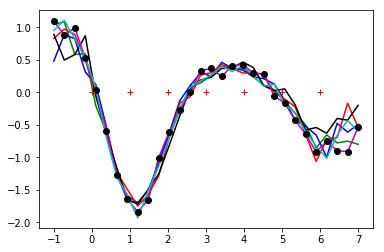

In [130]:
plt.plot(X_star, a2[0], 'g-')
plt.plot(X_star, a2[1], 'b-')
plt.plot(X_star, a2[2], 'r-')
plt.plot(X_star, a2[3], 'k-')
plt.plot(X_star, a2[4], 'm-')
plt.plot(X_star, a2[5], 'c-')
plt.plot(X_star, a2[4], 'ko')
# plt.plot(X, Y, 'mo')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')

#####  Generate plot for u 

In [131]:
def generate_u(alpha, rho, v, Xi):
    Kuu = kernel_rbf(alpha, rho, Xi=Xi)
    R = np.linalg.cholesky(Kuu)

    u_mean = np.dot(R, v)
    return u_mean

In [132]:
u_sum = np.zeros(M)
# S_sum = np.zeros((N,N))
for i in range(N_samples):
    u_mean = generate_u(alpha=alpha_samples[i], rho =rho_samples[i], v =eta_samples[i,:], Xi = X_u_noisy)
    u_sum = u_sum + u_mean

In [133]:
u_fin = u_sum / N_samples

Plot of inducing inputs and inducing outputs(u)

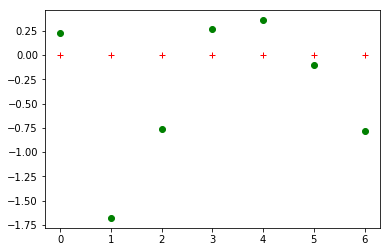

In [134]:
plt.plot(X_u_noisy, u_fin, 'go')
plt.plot(X_u_noisy, np.zeros(X_u_noisy.shape[0]), 'r+')